In [2]:
from fastai2.vision.all import *
from utils import *
import zipfile

In [7]:
with zipfile.ZipFile('bears.zip','r') as z_ref:
    z_ref.extractall()    

In [84]:
path = Path('bears')
path.ls()

(#3) [Path('bears/train.csv'),Path('bears/train'),Path('bears/.ipynb_checkpoints')]

In [119]:
df = pd.read_csv(path/'train.csv', sep=';')
df.tail()

,fname,labels,is_valid
423,grizzly_95.jpg,grizzly water,False
424,grizzly_96.jpg,grizzly,True
425,grizzly_97.jpg,grizzly water,False
426,grizzly_98.jpg,grizzly person,True
427,grizzly_99.jpg,grizzly,False


In [86]:
df.iloc[0]

fname       1.jpg
labels      teddy
is_valid     True
Name: 0, dtype: object

In [111]:
dblock=DataBlock()
dsets = dblock.datasets(df)

In [88]:
len(dsets.train), len(dsets.valid)

(343, 85)

In [89]:
x,y=dsets.train[0]
x,y

(fname       grizzly_118.jpg
 labels        grizzly water
 is_valid              False
 Name: 307, dtype: object,
 fname       grizzly_118.jpg
 labels        grizzly water
 is_valid              False
 Name: 307, dtype: object)

In [120]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y= lambda r: r['labels']) #need to define input & target for DataBlock
dsets = dblock.datasets(df)
dsets.train[0]

('grizzly_88.jpg', 'grizzly')

In [121]:
def get_x(r): return path/'train'/r['fname'] #path changed from 'train.csv' to 'train' to capture the actual image
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('bears/train/black_31.jpg'), ['black'])

In [122]:
dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock), get_x = get_x, get_y = get_y) #label output is multicategory
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=1220x813,
 TensorMultiCategory([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]))

In [93]:
idxs = torch.where(dsets.train[0][1]==1.)[0] #first training sample train[0] has label train[0][1]. If it is equal to '1' then take the first of that value
dsets.train.vocab[idxs]   #'vocab' converts 

(#2) ['black','tree']

In [149]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()    # indexes where column 'is valid' is FALSE. Convert indexes to list
    valid = df.index[df['is_valid']].tolist()
    return train, valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x,
                   get_y=get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=777x1000,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]))

In [150]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter = splitter,
                   get_x = get_x,
                   get_y = get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
                   
dls = dblock.dataloaders(df)        # datasets(df) changed to dataloaders(df)

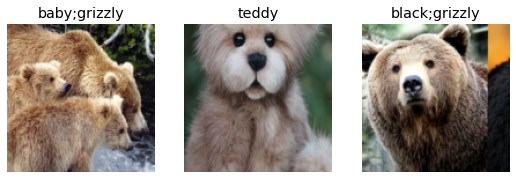

In [151]:
dls.show_batch(nrows=1, ncols=3)

In [117]:
learn = cnn_learner(dls, resnet18)

In [104]:
x,y = dls.train.one_batch()
activs = learn.model(x)
activs.shape

torch.Size([64, 18])

In [105]:
activs[0]

tensor([-0.3825,  0.3423, -0.2099,  0.0198, -2.0303,  3.7809,  1.0481, -1.0627,  0.2843,  1.1433,  1.4793,  2.2469,  0.5430, -1.9687,  2.4084, -1.2435, -1.1435,  1.4113], grad_fn=<SelectBackward>)

In [106]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

In [107]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

tensor(1.0726, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [108]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

In [135]:
learn = cnn_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.7)) #threshold too low fails to select correctly labeled objects
learn.fine_tune(5, base_lr=3e-3, freeze_epochs=4) #threshold too high selects objects for which model is too confident

epoch,train_loss,valid_loss,accuracy_multi,time
0,1.038938,1.274163,0.637885,00:27
1,0.999840,0.876420,0.721553,00:25
2,0.947265,0.713009,0.799866,00:25
3,0.904429,0.638953,0.848728,00:25


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.747380,0.623459,0.866131,00:30
1,0.733366,0.617200,0.874163,00:30
2,0.713999,0.596765,0.896921,00:30
3,0.697987,0.572112,0.908969,00:31
4,0.682386,0.555964,0.921017,00:30


In [138]:
learn.metrics = partial(accuracy_multi, thresh=0.8)
learn.validate()

(#2) [0.555964469909668,0.9578313231468201]

In [139]:
learn.metrics = partial(accuracy_multi, thresh=0.99) # I need to increase my threshold to minimize loss and maximize accuracy (try thresh = 0.8)
learn.validate()

(#2) [0.555964469909668,0.9712181687355042]

In [140]:
preds,targs = learn.get_preds()

In [141]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

tensor(0.9739)

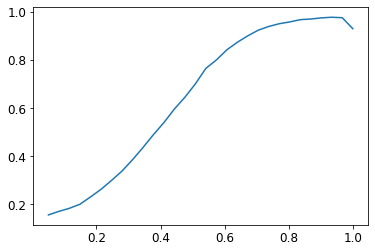

In [142]:
xs = torch.linspace(0.05,1.0,30)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

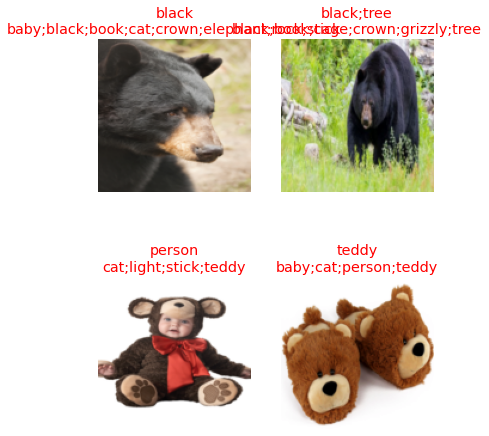

In [153]:
learn.show_results(ds_idx=1, max_n=4, figsize=(6,8))